  #                                        Livrable 3: Captionning 

### Contexte
#### Dans ce livrable, nous allons fournir un  L'objectif est de créer un réseau de neurones qui génère des légendes pour des photographies, en s'appuyant sur le dataset MS COCO. A la suite ce cela, nous avons un Workflow qui reprends les travaux réalisés durant l'ensemble du projet, afin de générer des légendes sur des images quelquonques.

## 1. Description du livrable 
Le livrable sera sous la forme d'un notebook Jupyter et va intégrer :

- L'architecture schématique complète du réseau utilisé pour le captioning explicitant le type de CNN utilisé pour les prétraitements.
- Explication du pré-traitements de images et du texte effectué.
- Le code explicitant l'architecture du CNN et du RNN utilisés dans le captioning.
- L'évolution sous forme de courbes des performances du réseau pendant l'entrainement et l'affichage de quelques exemples pour les tests.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

import numpy as np
import collections
import random
import re
import os
import json
import time
import pickle
import io

from tensorflow.python.ops import image_ops
from tensorflow.python.ops import io_ops
from tensorflow.keras.preprocessing import image as keras_image_ops

from glob import glob
from PIL import Image

## 1. Importation des données

L'objectif de cette partie est de préparer les données, à travers des prétraitements, pour pouvoir entraîner notre modèle à légender des images.

### a. choix du modèle de vectorisation d'images

Le captioning étant particulièrement lourd, nous utiliserons ici la méthode du transfert learning pour qui nous permettera de transformer nos images en vecteurs, afin qu'elles êtres légendées par notre modèle. Utiliser une méthode de transfert learning nous permets d'obtenir de bien meilleures performances que si on entrainait nous même un modèle de vectorisation d'images. Voici les différents modèles pré-entrainés et leur performances : 

<img src=https://cdn.discordapp.com/attachments/1030134555862118420/1032348477977530418/unknown.png width="600">

Nous avons donc choisi inceptionV3, car il propose une précision très haute avec très peu de paramètre. Etant donné notre faible capacité de calcul liée à nos ordinateur portable, c'est le choix qui correspond le mieux à nos besoins.

Dans le domaine de la recherche sur la vision par ordinateur, le projet ImageNet vise à étiqueter et à classer les images dans près de 22 000 catégories d'objets. 1,2 million d'images d'entraînement sont utilisées pour construire le modèle, 50 000 images supplémentaires pour la validation et 100 000 images pour le test. Le modèle Inception V3 proposé par Szegedy et al. possède une architecture CNN et a conduit à un nouvel état de l'art pour la classification et la détection. La caractéristique principale du modèle est sa conception qui améliore l'utilisation des ressources informatiques. La conception atteint cet objectif en permettant d'augmenter la profondeur et la largeur du modèle. Les poids d'Inception V3 sont plus petits que ceux de VGG et de ResNet, avec une taille totale de 96 Mo.

### b. chargement des données

Nous avons au préalable téléchargé le dataset MS COCO 2017. Ce dataset contient 123,287 images annotées chacune avec 5 légendes. Nous allons déclarer les variables stockant les chemins d'accès à ce dataset.

In [2]:
# Définition de la fonction de chargement d'image
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [3]:
# Chemin du fichier d'annotations
annotation_folder = "/Users/anisfaycalyagoub/Documents/LIVRABLE1G2/coco2017"
annotation_file = annotation_folder + "/annotations/captions_train2017.json"
# Chemin du dossier contenant les images
image_folder = '/train2017/'
PATH = "/Users/anisfaycalyagoub/Documents/LIVRABLE1G2/coco2017" + image_folder

Nous ajoutons ensuite un marqueur de début et de fin à chaque annotation et stockons celles-ci dans une collection ayant pour index les chemins d'accès des images liées aux annotations.

In [4]:
# Lecture du fichier d'annotation
with open(annotation_file, 'r') as f:
    annotations = json.load(f)  
# Groupe toutes les annotations ayant le meme identifiant.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
# marquer le debut et la fin de chaque annotation
    caption = f"<start> {val['caption']} <end>"
    image_path = PATH  + '%012d.jpg' % (val['image_id'])
# Rajout du caption associé à image_path
    image_path_to_caption[image_path].append(caption)

Nous prendrons ici un dataset de 20000 images pour avoir temps de calcul adéquat avec les performances de notre matériel informatique.

In [25]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)
train_image_paths = image_paths[:20000]

Les données sont ensuite stockée dans des tableaux.

In [26]:
# Liste de toutes les annotations
train_captions = []
# Liste de tous les noms de fichiers des images dupliquées (en nombre d'annotations par image)
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
     # Rajout de caption_list dans train_captions
    train_captions.extend(caption_list)
    # Rajout de image_path dupliquée len(caption_list) fois
    img_name_vector.extend([image_path] * len(caption_list))

Nous affichons la taille des tableaux. Nos tableaux on 100 000 entrées. Nous avons selectionnée aléatoirment 20 000 images, chacune de ces images ayant 5 annotations, on duplique chaque images 4 fois pour avoir un couple image, annotation.

Nous remarquons que nous n'obtenons pas les tailles de tableaux attendues. En effet, nous devrions avoir 20000 * 5 annotations soit 100000. Or, il a été remarqué que certaines images contenaient non pas 5 mais 6 annotations, ce qui explique les tailles obtenues.

100052 100052
<start> A large truck filled with produce driving down a street. <end>


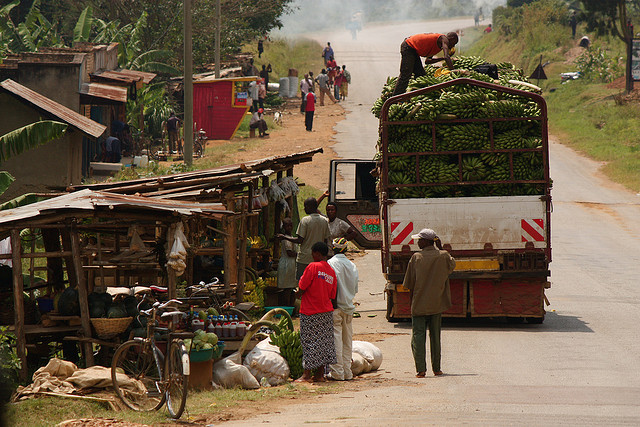

In [27]:
print(len(train_captions), len(img_name_vector))
print(train_captions[0])
Image.open(img_name_vector[0])

Ci dessus un exemple du dataset.

### c. chargement du model pré-entrainé InceptionV3

Nous pouvons maitenant selectionner la dernière couche du modèle Inceptionv3, celle qui nous intéresse pour vectoriser nos images.

In [28]:
# Telechargement du modèle InceptionV3 pré-entrainé avec la cassification sur ImageNet
image_model = tf.keras.applications.InceptionV3(include_top=False,
# Creation d'une variable qui sera l'entrée du nouveau modèle de pre-traitement d'images                                                weights='imagenet')
new_input = image_model.input
# récupérer la dernière couche caché qui contient l'image en representation compacte
hidden_layer = image_model.layers[-1].output
# Modèle qui calcule une representation dense des images avec InceptionV3
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

### d. pré-traitement des images

In [29]:
# Pré-traitement des images
# Prendre les noms des images
encode_train = sorted(set(img_name_vector))#trie les images
# Creation d'une instance de "tf.data.Dataset" partant des noms des images 
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# Division du jeu données en batchs après application du pré-traitement fait par load_image
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)
# Parcourir le dataset batch par batch pour effectuez le traitement d'InceptionV3
for img, path in image_dataset:
     # traitement du batch (de taille (16,8,8,2048)) courant par InceptionV3 
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

### e. pré-traitement des annotation
Pour faire de l'annotation nous devons avoir la possibilité de traiter le texte de manière automatique en suivant les étapes ci-dessous :
* Construire un vocabulaire des mots contenus dans les légendes. Pour cela nous devons tokeniser (diviser) les mots dans les légendes sur les caractères spéciaux (espaces, ponctuation, signes spéciaux, ....).
* Ce vocabulaire sera beaucoup trop volumineux, on devra se limiter par exemple aux 10000 premiers mots les plus fréquents. Nous remplacerons les autres mots par un token spécial nommé "UNK" (unknown).
* Les mots doivent aussi être numérotés dans le dictionnaire pour en former des annotations représentées de manière lisible pour les algorithmes de traitement de texte.
* Les exemples (annotations) seront remplis pour qu'ils aient tous la même taille (la taille maximale des annotations).

In [30]:
# Trouver la taille maximale 
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
# Chosir les 10000 mots les plus frequents du vocabulaire
top_k = 10000
#La classe Tokenizer permet de faire du pre-traitement de texte pour reseau de neurones
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
# Construit un vocabulaire en se basant sur la liste train_captions
tokenizer.fit_on_texts(train_captions)
# Créer le token qui sert à remplir les annotations pour egaliser leurs longueur
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
# Creation des vecteurs(liste de token entiers) à partir des annotations (liste de mots)
train_seqs = tokenizer.texts_to_sequences(train_captions)
# Remplir chaque vecteur à jusqu'à la longueur maximale des annotations
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
# Calcule la longueur maximale qui est utilisée pour stocker les poids d'attention 
max_length = calc_max_length(train_seqs)

Nous avons opté pour un top_k (les mots les plus frequents) d'un ordre de 10 000. 

En effet, nous avons testé plusieurs valeurs pour la variable top_k, (5000, 7500,12500,15000). Nous avons remarqué que en dessous de 10 000, nous avions un certain nombre de mots inconnus marqués avec la balise <unk>, ce qui n'était pas acceptable pour nous. 
    
Au delà de 10 000  pour la variable top_k, le temps de calcul augmente beaucoup, mais les résultats ne sont pas significativement meilleur pour que nous fassions ce choix. Nous sommes donc restés sur 10 000 mots pour la variable top_k.

Exemple de légende pour un top_k inférieur à 10 000: 
    
    
<img src=https://cdn.discordapp.com/attachments/1030134555862118420/1032591413692612618/Screenshot_2022-10-20_at_11.49.31.png width="200">
    
<img src=https://cdn.discordapp.com/attachments/1030134555862118420/1032591312794419332/Screenshot_2022-10-20_at_11.49.04.png width="600">



In [31]:
print(max_length)

51


### f. création des jeux d'entrainement et de test


Nous allons dans un premier temps créer d'un dictionnaire associant les chemins des images avec les annotations encodées.

In [32]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

Nous pouvons afficher un exemple, en récupérant un chemin d'image. Nous affichons ici l'encodage et le décodage de la première annotation de l'image récupérée.

In [33]:
path = img_name_vector[0]
encoded = img_to_cap_vector[path]
print("Chemin:", path)
print("Encodé:", encoded[0])
print("Décodé:", tokenizer.sequences_to_texts(np.expand_dims(encoded[0], axis=0)))

Chemin: /Users/anisfaycalyagoub/Documents/LIVRABLE1G2/coco2017/train2017/000000483557.jpg
Encodé: [  3   2  29 130 145   9 930 232  32   2  24   4   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Décodé: ['<start> a large truck filled with produce driving down a street <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']


Nous créons maintenant les jeux d'entrainement et de test.

In [34]:
# Prendre les clés (noms des fichiers d'images traites)
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)
# Diviser des indices en entrainement et test
slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]
# Boucle pour construire le jeu d'entrainement
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])
# Boucle pour construire le jeu de test  
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

    
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(80043, 80043, 20009, 20009)

## 2. Premières recherche d'architectures du modèle


### a. initialisation des paramètres du modèle

In [35]:
# Creation d'un dataset de "Tensor"s (sert à representer de grands dataset)
# Le dataset est cree a partir de "img_name_train" et "cap_train"
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
# Fonction qui charge les fichiers numpy des images prétraitées
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap
# L'utilisation de map permet de charger les fichiers numpy (possiblement en parallèle)
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

In [36]:
# La forme du vecteur extrait à partir d'InceptionV3 est (64, 2048)
# Les deux variables suivantes representent la forme de ce vecteur
features_shape = 2048
attention_features_shape = 64

BATCH_SIZE = 128 # taille du batch
BUFFER_SIZE = 1000 # taille du buffer pour melanger les donnes
embedding_dim = 256
units = 1048 # Taille de la couche caché dans le RNN
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

In [37]:
# Melanger les donnees et les diviser en batchs
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

### b. description de l'architecutre de l'encodeur CNN

Par rapport au modèle, la dernière couche convolutive d'`InceptionV3` est de la forme `(8, 8, 2048)`. Ce vecteur a été remodelé en la forme `(64, 2048)` lors de du stockage au niveau du disque. Ce vecteur est ensuite passé à travers l'encodeur CNN (qui se compose d'une seule couche entièrement connectée). Le RNN s'occupera de prédire pour ce vecteur le mot suivant dans l'annotation. L'image ci-dessous reprend un exemple d'une architecture d'un système d'annotation utilisant un CNN et un RNN.


<img src=https://media.discordapp.net/attachments/1030134555862118420/1032525178506313848/unknown.png width="600">

Dans cet exemple le captioning se fait de cette façon:
<ul>
    <li>L'image est passée à travers le CNN pour avoir une représentation compacte de celui-ci. Cette représentation est retournée par la couche `Dense 2` de taille 2048.</li>
    <li>Cette représentation est réduite en la passant à la couche dense `Dense map` pour être mise en entrée comme état caché initial aux cellules du RNN.</li>
    <li>La partie RNN est composée de GRU (Gated Reccurent Unit). Cette partie est constituée de 3 couches. Une couche représentant de manière assez sommaire un niveau d'abstraction du langage.</li>
    <li>Le RNN a en entrée l'annotation ainsi que l'image en forme compacte, et retourne pour chaque colonne le mot suivant le mot en entrée au niveau de la colonne.</li>
    <li>Les annotations sont représentées en liste de mots. Cette liste est inexploitable par le RNN, elle est donc passée à un module qui remplace chaque mot par un entier (ou jeton entier), puis par un autre module qui projette chaque jeton en un vecteur dont les éléments sont entre -1 et 1.</li>
</ul>

Notre système d'annotation suivra de manière assez globale, le même principe que montrée dans l'image ci-dessous, néanmoins il contiendra des différences essentielles le distinguant de cet exemple. Le système contiendra, notamment, un mécanisme d'attention dont la fonction est d'amener le réseau de neurones à donner une plus grande importance dans ses prédictions de l'annotation aux parties de l'image les plus parlantes et les plus pertinentes

L'encodeur CNN produit une représentation adéquate de l'image qu'il transmet au décodeur RNN pour la légender. Le CNN a en entrée les caractéristiques des images déjà prétraitées par InceptionV3 et stockées sur le disque.

Contrairement à un CNN classique, la dernière couche convolutive n’est pas totalement aplatie. En effet, les images issues du prétraitement par InceptionV3 étaient de la forme 8x8x2048. Ces images ont été remodelées pour avoir la taille 64x2048. Cela signifie que cette représentation contient pour chacune des 64 positions de l’image prétraitée les 2048 caractéristiques extraites par InveptoinV3. Et donc, l’entrée du décodeur CNN est un batch ou chaque élément est constitué des 2048 caractéristiques des 64 positions de l’image prétraitée. La couche dense qui suit calcule une nouvelle représentation de l’image de taille 64x256 ou chaque position de l’image a donc 256 caractéristiques.

L’avantage de cette représentation par rapport à la représentation aplatie est de préserver de l’information spatiale au niveau des couches du réseau de neurones. Ceci permettra au mécanisme d’attention de la partie RNN de détecter les positions intéressantes au niveau de l’image et de renseigner l’algorithme sur quelle zone il devra porter le plus d’importance pour légender l’image.

In [38]:
class CNN_Encoder(tf.keras.Model):
    # Comme les images sont déjà prétraités par InceptionV3 est représenté sous forme compacte
    # L'encodeur CNN ne fera que transmettre ces caractéristiques à une couche dense
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # forme après fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

### c. le mécanisme d'attention
Le mécanisme d’attention ressemble beaucoup à une cellule RNN, mais avec quelques différences. La partie de l’attention a en entrée la représentation de l’image prétraité retourner par le CNN ainsi que la valeur courante de l’état cachée du GRU, et en sortie le **vecteur du contexte** qui reflète les caractéristiques les plus importantes de l’image. Une étape intermédiaire pour calculer ce vecteur consiste à calculer les **poids d’attention** qui représentent l’importance de chaque position de l’image (il y en a 64) dans la prédiction de son annotation.

La représentation de l’image donnée en entrée est transformée au début de la même manière que pour le CNN en la passant à une couche dense de taille `units`. De même, l’état caché est aussi passé à une couche dense de taille `units`. La nouvelle représentation de l’image est ensuite additionnée à l’état caché puis passée à une fonction d’activation de type **tanh** comme pour les cellules classiques de RNN. À ce niveau-là, on aura une représentation des données de taille `64xunits` contenant un mélange d’informations sur l’image et sur le texte de l’annotation. Un score est ensuite associé à chacune des positions en passant cette représentation à une couche dense. Ces scores sont normalisés avec une couche softmax pour produire le vecteur des **poids d’attention**. 

Finalement, chaque caractéristique de la représentation de l’image en entrée sera multipliée (pondérée) par le vecteur d’attention. Après quoi, on prend la somme de chaque caractéristique le long des positions (les lignes de la représentation) pour former le **vecteur du contexte**.

De façon globale, on peut dire que le vecteur d’attention dépend de scores qui sont appris à partir d’une représentation spatiale et textuelle de l’image. Ce vecteur d’attention renvoie la pertinence de chaque position et sert à calculer le vecteur du contexte qui nous donnera l’importance des caractéristiques de l’image.

In [39]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer)

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

### d. modèle RNN : les différentes possibilités

Le rôle du décodeur RNN est d’utiliser la représentation prétraitée de l’image de prédire sa légende mot par mot. 

#### 1. RNN ( Réseaux de neurones récurrents )

<img src=https://media.discordapp.net/attachments/763010597309775882/1032583936712396841/unknown.png width="600">
Les couches cachées aident le RNN à se souvenir de la séquence de mots (données) et à utiliser le modèle de séquence pour la prédiction.

L'idée du RNN a beaucoup évolué. Il a été utilisé pour la reconnaissance vocale et diverses tâches NLP où la séquence des mots est importante. Le RNN prend l'entrée comme une série temporelle (séquence de mots), nous pouvons dire que le RNN agit comme une mémoire qui se souvient de la séquence.

Cas d'utilisation des RNN :

- Reconnaissance de la parole, du texte et classification des sentiments
- Synthèse musicale
- Sous-titrage d'images
- Chatbots et NLP
- Traduction automatique - Traduction de la langue
- Prédictions boursières
- Détection et blocage des mots abusifs dans un discours ou un texte


Problèmes avec les RNN :

- Problèmes d'explosion et de disparition des gradients lors de la rétropropagation.

- Les gradients sont les valeurs qui permettent de mettre à jour les poids des réseaux neuronaux. En d'autres termes, on peut dire que le gradient est porteur d'information.

- La disparition du gradient est un gros problème dans les réseaux neuronaux profonds. Il disparaît ou explose rapidement dans les couches antérieures, ce qui rend le RNN incapable de retenir les informations d'une séquence plus longue, et donc le RNN devient une mémoire à court terme.

- Si nous appliquons le RNN pour un paragraphe, le RNN peut laisser de côté des informations nécessaires en raison des problèmes de gradient et ne pas être capable de transporter des informations de l'étape initiale à des étapes ultérieures.

Pour résoudre ce problème, les LSTM et les GRU sont apparus.

La raison de l'explosion du gradient était la capture des informations pertinentes et non pertinentes. un modèle qui peut décider quelles informations d'un paragraphe et pertinentes et ne retenir que les informations pertinentes et jeter toutes les informations non pertinentes.

La LSTM (mémoire à long et court terme) et la GRU (Gated Recurrent Unit) ont des portes comme mécanisme interne, qui contrôlent les informations à conserver et celles à rejeter. En faisant cela, les réseaux LSTM et GRU résolvent le problème de l'explosion et de la disparition du gradient.

Presque tous les modèles SOTA (state of the art) basés sur les RNN utilisent les réseaux LSTM ou GRU pour la prédiction.

Les LSTMs /GRUs sont implémentés dans la reconnaissance vocale, la génération de texte, la génération de sous-titres, etc.

Nous avons deux possibilités qui répondent à notre problématique, soit nous utilisons un RNN avec LSTM, soit nous utilisons un RNN avec GRU.


#### 2. Réseaux LSTM

Chaque réseau LSTM contient essentiellement trois portes pour contrôler le flux d'informations et des cellules pour contenir les informations. Les états cellulaires transportent l'information d'un pas de temps initial à un pas de temps ultérieur sans se volatiliser.


<img src=https://cdn.discordapp.com/attachments/763010597309775882/1032584114307608586/unknown.png width="600">
                                                                    
Les portes utilisent l'activation sigmoïde ou l'activation tanh. Les valeurs de l'activation tanh sont comprises entre 0 et 1.


- ***Forget Gate*** :
Cette porte décide quelles informations doivent être reportées en avant ou quelles informations doivent être ignorées.

Les informations des états cachés précédents et les informations de l'état actuel passent par la fonction sigmoïde. Les valeurs qui sortent de la fonction sigmoïde sont toujours entre 0 et 1. Si la valeur est plus proche de 1, cela signifie que l'information doit être transmise et si la valeur est plus proche de 0, cela signifie que l'information doit être ignorée.

- ***Porte d'entrée*** :

Après avoir décidé de l'information pertinente, l'information va à la porte d'entrée, la porte d'entrée transmet l'information pertinente, et cela conduit à la mise à jour des états de la cellule, en sauvegardant simplement la mise à jour du poids.

La porte d'entrée ajoute la nouvelle information pertinente à l'information existante en mettant à jour les états des cellules.

- ***Porte de sortie*** :

Après que l'information soit passée par la porte d'entrée, la porte de sortie entre en jeu. La porte de sortie génère les prochains états cachés et les états des cellules sont reportés au pas de temps suivant.



#### 3.GRU

<img src=https://cdn.discordapp.com/attachments/763010597309775882/1032584360739753986/unknown.png width="600">

Les GRU (Gated Recurrent Units) sont similaires aux réseaux LSTM. GRU est une sorte de nouvelle version de RNN. Cependant, il y a quelques différences entre GRU et LSTM.

GRU ne contient pas d'état de cellule
GRU utilise ses états cachés pour transporter l'information
Il ne contient que 2 portes (porte de réinitialisation et de mise à jour).
GRU est plus rapide que LSTM
GRU a moins d'opérations tensorielles, ce qui le rend plus rapide.
###### Porte de mise à jour

La porte de mise à jour est une combinaison de la porte d'oubli et de la porte d'entrée. La porte d'oubli décide de l'information à ignorer et de l'information à ajouter en mémoire.

###### Porte de réinitialisation

Cette porte réinitialise les informations passées afin de se débarrasser de l'explosion du gradient. La porte de réinitialisation détermine combien d'informations passées doivent être oubliées.


#### 4. Tests effectués

Après plusieurs recherches, nous avons choisi d'utiliser GRU plutot que LSTM. Selon cette recherche [(source)](https://ieeexplore.ieee.org/document/9221727), les réseaux de neurones GRU s'entraînent plus rapidement et ont de meilleures performances que les LSTM avec moins de données d'entraînement. 

Un réseau GRU a des performances comparables à celles d'un réseau LSTM, mais il est plus efficace sur le plan informatique puisqu'il est moins complexe et donc utilise moins de ressources. Etant donné la capacité de notre matériel informatique, nous avons donc choisi d'implémenter GRU, ce qui nous permet d'avoir un temps de calcul moindre.


### d. modèle RNN : les différentes possibilités

Le rôle du décodeur RNN est d’utiliser la représentation prétraitée de l’image de prédire sa légende mot par mot. 

Nous avons deux possibilités qui répondent à notre problématique, soit nous utilisons un RNN avec LSTM, soit nous utilisons un RNN avec GRU.


- #### LSTM

## 3. Architecture finale du modèle


### a. architecture finale choisie

Comme décrit plus haut, nous avons choisi d'utiliser GRU. Ce RNN à une seule cellule du type GRU. Le GRU a un état caché qui représente la mémoire des derniers éléments vu par celui-ci. Le GRU met à jour son état avant de le retourner, pour cela il utilise certains mécanismes de mémorisation qui sont assez sophistiqués.

Le décodeur est structuré comme suit, à chaque appel du RNN, le mot courant ainsi que la représentation de l’image et l’état caché du GRU sont donnés en entrée du RNN. Comme les mots sont représentés par des entiers, on doit faire passer ceux-ci par une couche dite embedding layer qui se chargera de calculer une représentation vectorielle de taille `output dim` partant du nombre représentant le mot.

À côté de ça, le mécanisme d’attention fournit un vecteur représentant **le contexte** de l’image, c-à-d un vecteur qui nous renseigne sur les caractéristiques dominantes de l’image. Ce vecteur est calculé par un appel du mécanisme d’attention en lui fournissant en entrée les caractéristiques de l’image encodées par le CNN ainsi que l’état caché du GRU qui résume l’historique des mots vu par le RNN jusqu’à présent. 

Ensuite, le mot courant et le contexte sont concaténés pour former le vecteur d’entrée du GRU qui à son tour calcule l'état à l'étape suivant. Cet État est passée par une couche dense de taille `units` puis la sortie de cette couche est passée à une autre couche dense de taille `vocab sise` qui retourne le score associé à chaque mot du vocabulaire afin de prédire le mot suivant.

In [40]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)

        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)

        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)

        return x, state, attention_weights
    


### b. encodeur CNN et decodeur RNN

In [41]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [42]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

Nous allons maintenant implementer deux fonctions : `train_step` et `evaluate` :

- La fonction `train_step` représente une étape de l'entrainement du réseau. Elle est composée de l'évaluation par l'encodeur du vecteur précalculé par InceptionV3. La sortie de cette étape sera transmise au décodeur qui se charge de prédire l'annotation mot par mot. La boucle pour prédire chaque mot et calculer la perte associée devra être implémentée dans cette fonction.
- La fonction `evaluate` servira à évaluer les performances du réseau sur le jeu de test. Elle est donc similaire à la fonction `train_step` sauf que la partie calcule de la fonction de perte et absente car il n'agit pas d'entrainer le réseau.

La fonction a en entrée un batch d'images prétraitées ainsi que leurs annotations et retourne la perte associée à ce batch. 

L'état caché de la partie RNN est initialisé ainsi que le mot de départ avec le token de début. Les caractéristiques de l'image sont ensuite extraites par l’encodeur. Après cela, on parcourt le batch mot par mot pour prédire le mot suivant à l'aide du décodeur. Le décodeur utilise l'état caché, les caractéristiques de l'image ainsi que le mot précédent pour prédire le mot courant. Le décodeur met à jour l'état caché et le retourne ainsi que les prédictions du batch. La perte est calculée à partir des prédictions retournées par le décodeur et les annotations associées au batch.

Finalement, la perte globale ainsi que le gradient sont calculés et le réseau est mis à jour.

In [43]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0

    hidden = tf.zeros((target.shape[0], units))

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

### c. résultats des différents tests effectués

Nous avons testé 3 combinaisons de paramètres. 

<img src=https://cdn.discordapp.com/attachments/1030134555862118420/1032609668192800839/Screenshot_2022-10-20_at_13.02.04.png width=600>

- ###### Modèle 1
Dans un premier temps, nous avons essayé d'entrainé notre modèle avec 30 000 images, un dictionnaire de 5 000 mots réccurents, et 15 Epochs. Les problèmes avec ce modèle sont le suivants : nous avions assez de données, mais le nombre de mots réccurents est trop faible par rapport à nos données, ce qui nous génère un certain nombre de légendes avec une balise inconnue (<unk>). Le nombre d'epochs est également faible par rapport au volumes des données, nous n'obtenons donc pas de stabilisation de la fonction de perte. Ce modèle n'est donc pas satisfaisant.

- ###### Modèle 2
Ensuite, nous avons entrainé notre modèle avec moins de données, 2 000, un dictionnaire de 5 000 mots réccurents et 175 epochs. Les problèmes avec ce modèle sont les suivants : nous n'avions pas assez de données, ce qui fait que la génération de texte n'est pas adéquate sur les données test, car la plupart des objets de ce dataset sont inconnus. De plus, le nombre d'epochs que nous avons est trop élevé pour le nombre de données que nous avons. La conséquence est que le modèle génère un très grand nombre de batchs (liées à la fonction dynamique de génération de batch), ce qui crée des oscillations sur la courbe de la fonction de perte. Ce modèle n'est donc pas satisfaisant.

- ###### Modèle 3
Pour le troisième essai, nous avons augmenté le nombre de données à 20 000, avec un dictionnaire de 10 000 mots réccurents, et 30 epochs. Ce modèle nous fournit des résultats meilleurs que les deux modèles précédents, car nous n'avons presque pas de balises inconnues lors des légendes, mais le faible nombre d'epochs ne permet pas la stabilisation de la fonction de perte. Ce modèle n'est donc pas satisfaisant.
    
- ###### Modèle 4
Enfin, pour le dernier essai, nous avons pris les mêmes paramètres que le modèle précédent, à l'exception du nombre d'epochs qui est à présent de 80. Ce modèle génère des légendes sans balises inconnues, arrive à reconnaître un très nombre d'objets, et sa fonction de perte se stabilise, comme montré sur le tableau plus haut. 
    
Nous allons donc choisir les paramètres du modèle 4, car il répond parfaitement à nos besoins.

### d. entrainement du modèle final

Nous devons utiliser cette fonction dans un d'entrainement. Cette boucle parcourt le jeu de données d'entrainement batch par batch et entraine les réseaux avec ceux-ci.

2022-10-18 20:35:19.511555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:35:24.523649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:35:24.718266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:35:24.907698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:35:24.991068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:35:25.072121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:35:25.160086: I tensorflow/core/grappler/optimizers/cust

2022-10-18 20:35:31.058141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:35:31.256188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:35:31.569464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:35:31.789403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:35:31.992188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:35:32.188279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:35:32.384141: I tensorflow/core/grappler/optimizers/cust

Epoch 1 Batch 0 Loss 2.0559
Epoch 1 Batch 100 Loss 1.0009
Epoch 1 Batch 200 Loss 0.8785
Epoch 1 Batch 300 Loss 0.8523
Epoch 1 Batch 400 Loss 0.7588
Epoch 1 Batch 500 Loss 0.7483
Epoch 1 Batch 600 Loss 0.7659


2022-10-18 20:48:08.104290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:48:12.963763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:48:13.654466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:48:13.826320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:48:13.987648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:48:14.114715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:48:14.268827: I tensorflow/core/grappler/optimizers/cust

2022-10-18 20:48:21.204744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:48:21.475013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:48:21.749428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:48:22.023928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:48:22.298404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:48:22.571271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-18 20:48:22.848941: I tensorflow/core/grappler/optimizers/cust

Epoch 1 Loss 0.871235
Time taken for 1 epoch 810.61 sec

Epoch 2 Batch 0 Loss 0.7561
Epoch 2 Batch 100 Loss 0.6988
Epoch 2 Batch 200 Loss 0.6979
Epoch 2 Batch 300 Loss 0.7138
Epoch 2 Batch 400 Loss 0.6869
Epoch 2 Batch 500 Loss 0.6735
Epoch 2 Batch 600 Loss 0.6609
Epoch 2 Loss 0.692239
Time taken for 1 epoch 728.61 sec

Epoch 3 Batch 0 Loss 0.6532
Epoch 3 Batch 100 Loss 0.6798
Epoch 3 Batch 200 Loss 0.6529
Epoch 3 Batch 300 Loss 0.6763
Epoch 3 Batch 400 Loss 0.6257
Epoch 3 Batch 500 Loss 0.5919
Epoch 3 Batch 600 Loss 0.5796
Epoch 3 Loss 0.641071
Time taken for 1 epoch 734.32 sec

Epoch 4 Batch 0 Loss 0.6723
Epoch 4 Batch 100 Loss 0.6323
Epoch 4 Batch 200 Loss 0.6195
Epoch 4 Batch 300 Loss 0.6071
Epoch 4 Batch 400 Loss 0.6298
Epoch 4 Batch 500 Loss 0.5849
Epoch 4 Batch 600 Loss 0.5797
Epoch 4 Loss 0.605774
Time taken for 1 epoch 760.07 sec

Epoch 5 Batch 0 Loss 0.6004
Epoch 5 Batch 100 Loss 0.5900
Epoch 5 Batch 200 Loss 0.5594
Epoch 5 Batch 300 Loss 0.5975
Epoch 5 Batch 400 Loss 0.5030


Epoch 32 Batch 100 Loss 0.2471
Epoch 32 Batch 200 Loss 0.2499
Epoch 32 Batch 300 Loss 0.2367
Epoch 32 Batch 400 Loss 0.2362
Epoch 32 Batch 500 Loss 0.2462
Epoch 32 Batch 600 Loss 0.2332
Epoch 32 Loss 0.241647
Time taken for 1 epoch 758.19 sec

Epoch 33 Batch 0 Loss 0.2476
Epoch 33 Batch 100 Loss 0.2429
Epoch 33 Batch 200 Loss 0.2396
Epoch 33 Batch 300 Loss 0.2245
Epoch 33 Batch 400 Loss 0.2261
Epoch 33 Batch 500 Loss 0.2453
Epoch 33 Batch 600 Loss 0.2238
Epoch 33 Loss 0.237471
Time taken for 1 epoch 758.73 sec

Epoch 34 Batch 0 Loss 0.2554
Epoch 34 Batch 100 Loss 0.2415
Epoch 34 Batch 200 Loss 0.2305
Epoch 34 Batch 300 Loss 0.2222
Epoch 34 Batch 400 Loss 0.2170
Epoch 34 Batch 500 Loss 0.2116
Epoch 34 Batch 600 Loss 0.2361
Epoch 34 Loss 0.233499
Time taken for 1 epoch 758.72 sec

Epoch 35 Batch 0 Loss 0.2451
Epoch 35 Batch 100 Loss 0.2495
Epoch 35 Batch 200 Loss 0.2366
Epoch 35 Batch 300 Loss 0.2280
Epoch 35 Batch 400 Loss 0.2340
Epoch 35 Batch 500 Loss 0.2087
Epoch 35 Batch 600 Loss 0.

Epoch 62 Batch 200 Loss 0.1913
Epoch 62 Batch 300 Loss 0.1720
Epoch 62 Batch 400 Loss 0.1655
Epoch 62 Batch 500 Loss 0.1735
Epoch 62 Batch 600 Loss 0.1825
Epoch 62 Loss 0.177320
Time taken for 1 epoch 724.99 sec

Epoch 63 Batch 0 Loss 0.1730
Epoch 63 Batch 100 Loss 0.1828
Epoch 63 Batch 200 Loss 0.1871
Epoch 63 Batch 300 Loss 0.1860
Epoch 63 Batch 400 Loss 0.1548
Epoch 63 Batch 500 Loss 0.1822
Epoch 63 Batch 600 Loss 0.1736
Epoch 63 Loss 0.176648
Time taken for 1 epoch 725.41 sec

Epoch 64 Batch 0 Loss 0.1796
Epoch 64 Batch 100 Loss 0.1636
Epoch 64 Batch 200 Loss 0.1816
Epoch 64 Batch 300 Loss 0.1834
Epoch 64 Batch 400 Loss 0.1647
Epoch 64 Batch 500 Loss 0.1630
Epoch 64 Batch 600 Loss 0.1710
Epoch 64 Loss 0.175209
Time taken for 1 epoch 730.24 sec

Epoch 65 Batch 0 Loss 0.1660
Epoch 65 Batch 100 Loss 0.1764
Epoch 65 Batch 200 Loss 0.1786
Epoch 65 Batch 300 Loss 0.1746
Epoch 65 Batch 400 Loss 0.1699
Epoch 65 Batch 500 Loss 0.1613
Epoch 65 Batch 600 Loss 0.1742
Epoch 65 Loss 0.175660
Tim

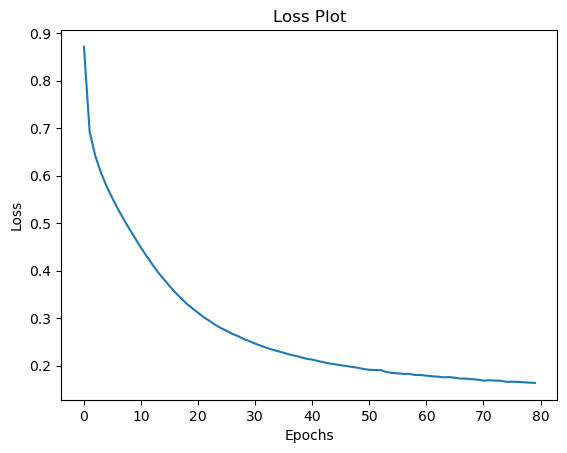

In [44]:
start_epoch = 0
EPOCHS = 80

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    loss_plot.append(total_loss / num_steps)

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

### e. test du modèle final


La fonction qui permet d'achever une étape d'évaluation pour le test est dans la cellule suivante.

In [45]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = tf.zeros((1, units))

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [46]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [47]:
def open_image (path):
    image = io_ops.read_file(path)
    image = image_ops.decode_image(image, 3, expand_animations=False)
    image = keras_image_ops.smart_resize(image, (299, 299), interpolation='bilinear')
    return image / 255

/Users/anisfaycalyagoub/Documents/LIVRABLE1G2/coco2017/train2017/000000350344.jpg
Real Caption: <start> a woman with two children holds a kite <end>
Prediction Caption: a group of people watching <end>


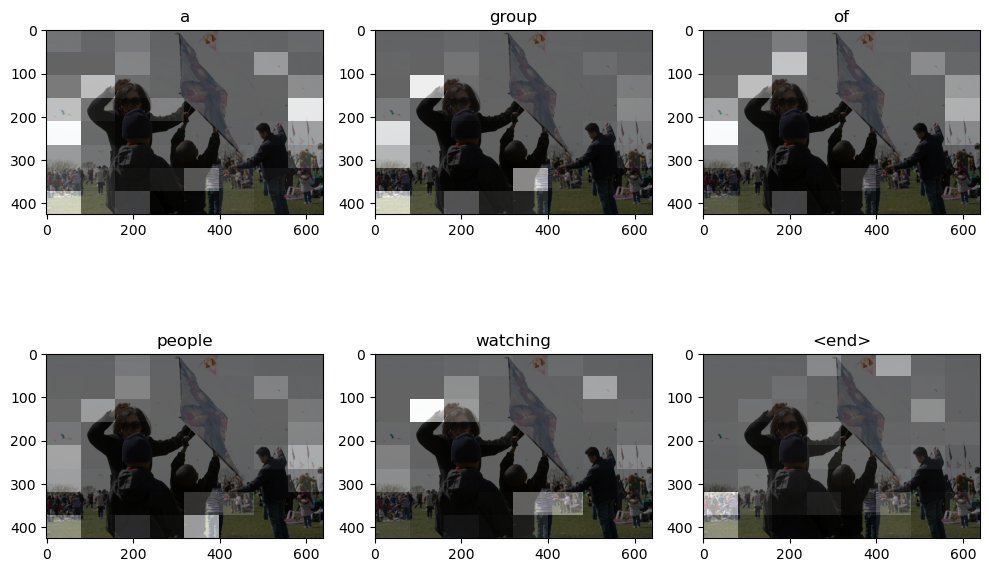

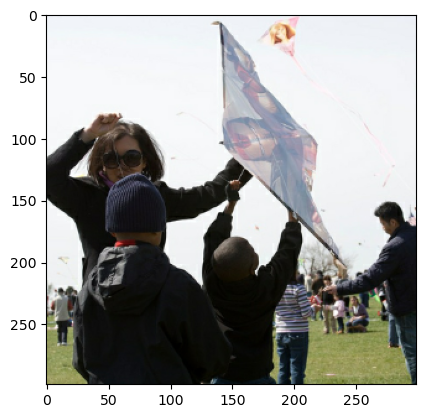

In [61]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i]
                            for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
plt.imshow(open_image(image))

Real Caption: <start> a desk with two computer monitors and a keyboard on it <end>
Prediction Caption: a small desk with a monitor and monitor <end>


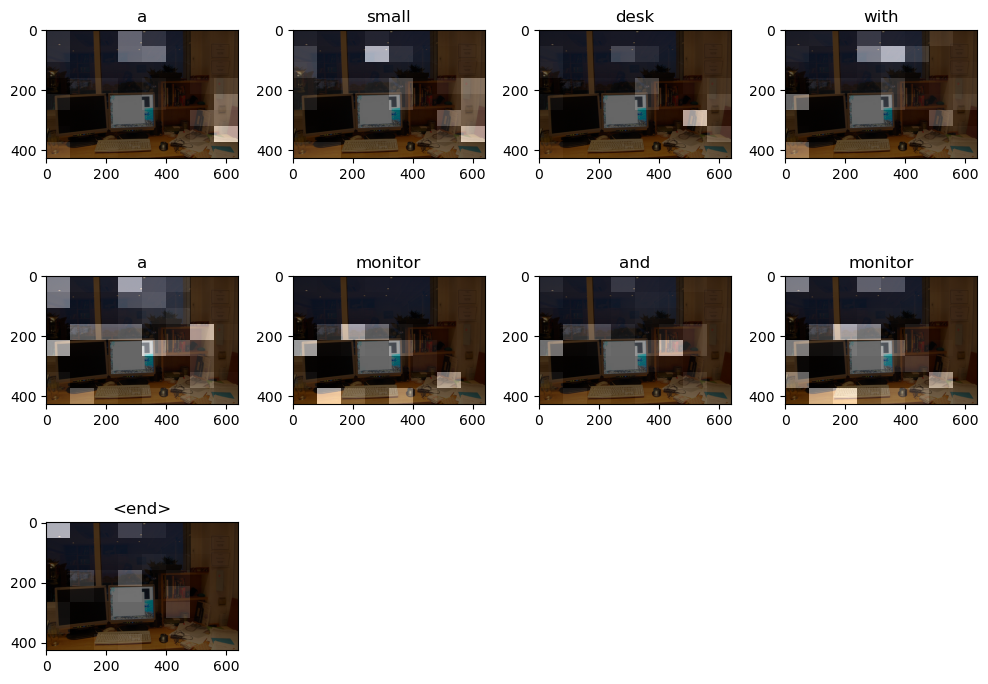

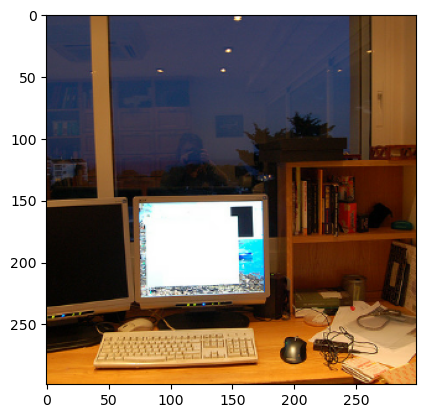

In [49]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                            for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
plt.imshow(open_image(image))

### Enregistrement du modèle

In [55]:
image_features_extract_model.save('/Users/anisfaycalyagoub/Desktop/ model/save captioning models/image_features_extract_model')
encoder.save('/Users/anisfaycalyagoub/Desktop/ model/save captioning models/encoder')
decoder.save('/Users/anisfaycalyagoub/Desktop/ model/save captioning models/decoder')

tokenizer_json = tokenizer.to_json()
with io.open('/Users/anisfaycalyagoub/Desktop/Save model/save captioning models/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

INFO:tensorflow:Assets written to: /Users/anisfaycalyagoub/Desktop/ model/save captioning models/image_features_extract_model/assets


INFO:tensorflow:Assets written to: /Users/anisfaycalyagoub/Desktop/ model/save captioning models/image_features_extract_model/assets


INFO:tensorflow:Assets written to: /Users/anisfaycalyagoub/Desktop/ model/save captioning models/encoder/assets


INFO:tensorflow:Assets written to: /Users/anisfaycalyagoub/Desktop/ model/save captioning models/encoder/assets


INFO:tensorflow:Assets written to: /Users/anisfaycalyagoub/Desktop/ model/save captioning models/decoder/assets


INFO:tensorflow:Assets written to: /Users/anisfaycalyagoub/Desktop/ model/save captioning models/decoder/assets


# Workflow Final

Ce partie regroupe le travail effectué durant l'ensemble du projet. Nous avons mis en place un workflow qui execute les tâches suivantes, dans l'ordre.

- nettoyage du dossier d'images
- classification des images en "photo" ou "autre"
- défloutage des photos
- débruitage des photos
- génération d'une annotation/légende des photos

Nous allons dans un premier temps importer les modules nécéssaires et spécifier le dossier d'images auquel nous appliquerons ce workflow. Nous supprimons également les dossiers cachés éventuels.

In [240]:
import os
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.ops import image_ops
from tensorflow.python.ops import io_ops 
from keras.models import load_model
from tensorflow.keras.utils import array_to_img

import matplotlib.pyplot as plt
from tensorflow.python.ops import image_ops
from tensorflow.python.ops import io_ops 
import numpy as np
from matplotlib import cm

#DOSSIER D'IMAGES
DATA_DIR = './test set/'
DENOISED_IMAGES_DIR = './denoised'

for folder in os.listdir(DATA_DIR):
    if folder.startswith('.'):
        os.remove(os.path.join(DATA_DIR, folder))

Nos modèles sont tous sauvegardés dans le dossier où nous nous trouvons, comme ceci :

In [241]:
!ls

Liv3.ipynb                autoencoder.h5            denoised
Livrable_3 - GF.ipynb     classification_binaire.h5 test set


In [242]:
#importation des modèles

#importation du modèle de classification
classification_binaire = tf.keras.models.load_model('classification_binaire.h5')

#importation du modèle de debruitage
denoiser = tf.keras.models.load_model('autoencoder.h5')

Nous allons maintenant implémenter 3 fonctions qui vont préparer chaque image au traitement qu'elle subira par modèle, et qui vont interpréter les résultats.

In [244]:
def classifier_image(path):
    image = io_ops.read_file(path)
    image = image_ops.decode_image(image, 3)
    image = tf.keras.preprocessing.image.smart_resize(image, (256, 256), interpolation='bilinear')
    image = np.array(image) / 255
    pred = classification_binaire.predict(np.expand_dims(image, axis=0))
    
    prediciton = "Other"
    if pred > 0.5:
        prediciton = "Photo"
    return prediciton
    
def debruiter_image(path):    
    image = io_ops.read_file(path)
    image = image_ops.decode_image(image, 3)
    image = tf.keras.preprocessing.image.smart_resize(image, (400, 400), interpolation='bilinear')
    image = np.array(image) / 255

    denoised = denoiser.predict(np.expand_dims(image, axis=0))
    new_img=array_to_img(np.squeeze(denoised, axis=0))
    p = path.replace(DATA_DIR, "")
    denoised_path = os.path.join(DENOISED_IMAGES_DIR,p)
    new_img.save(denoised_path)
    return denoised_path

def final_workflow(path):
    
    img_classification = classifier_image(path)

    if img_classification == "Other":
        return img_classification, None, None, None
    
    denoised_img = debruiter_image(path)
    
    result, attention_plot = evaluate(denoised_img)
    
    return img_classification, denoised_img, result, attention_plot


Nous allons maintenant parcourir le dossier des images à tester, et les envoyers vers notre workflow.

In [245]:
imgs_path = []
imgs_classification = []
imgs_denoising = []
results = []
attention_plots = []


# Parcours le dossier contenant les photos

for file in os.listdir(DATA_DIR):
        img_classification, img_denoising, result, attention_plot = final_workflow(os.path.join(DATA_DIR,file))
        
        imgs_path.append(os.path.join(DATA_DIR,file))
        imgs_classification.append(img_classification)
        imgs_denoising.append(img_denoising)
        results.append(result)
        attention_plots.append(attention_plot)

1/1 [==============================] - 0s 28ms/step


existing options : from 0 to 16
Classifcation: Other
Classifcation: Photo
Prediction Caption: a train is driving down a track <end>


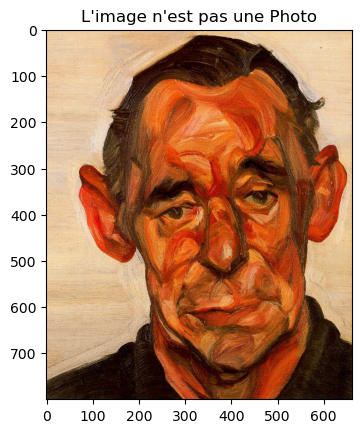

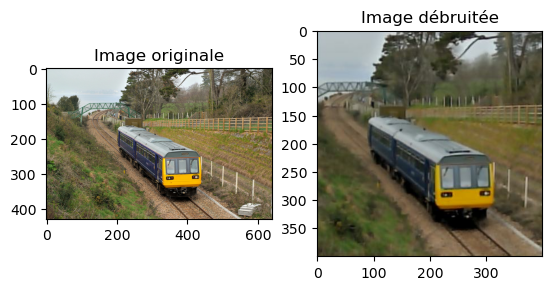

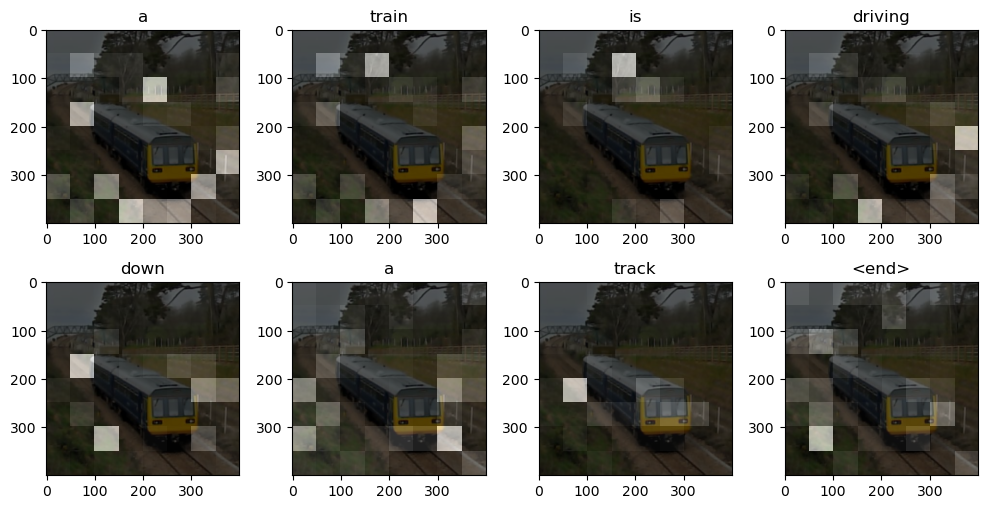

In [246]:
def print_results(index):
        
    print("Classifcation:", imgs_classification[index])
    i = io_ops.read_file(imgs_path[index])
    i = image_ops.decode_image(i, 3)
    if imgs_classification[index] != "Other":
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(i)
        ax1.set_title("Image originale")
        denoised_i = io_ops.read_file(imgs_denoising[index])
        denoised_i = image_ops.decode_image(denoised_i, 3)
    else:
        plt.imshow(i)
        plt.title("L'image n'est pas une Photo")
        return
    if imgs_classification[index] != "Other":
        print('Prediction Caption:', ' '.join(results[index]))
        ax2.imshow(denoised_i)
        ax2.set_title("Image débruitée")
        plot_attention(imgs_denoising[index], results[index], attention_plots[index])

print("existing options : from 0 to " + str(len(imgs_path)-1))
    
print_results(4)

print_results(8)

Nous pouvons voir que les légendes générées sur ces données test, qui ont été classifiées et débruitées au préalable sont plutot correctes. En effet, ces photos provienne du dataset **COCO 2014**, que ne n'avons pas du tout utilisé lors de l'entrainement de notre modèle. De plus, nous avons également inclu des images qui ne sont pas des photos, qui provienne du dataset de la 1ère phase du projet.

# Conclusion

L'ensemble du projet à été mené à bien. Nous avons un premier prototype de Workflow qui fonctionne plutôt bien, dans le sens où les légendes générées par celui ci sont réalistes. Etant donné les données que nous avons utilisé pour entrainter l'ensemble de nos modèles, les résultats sont assez satisfaisants.

Nous pouvons encore améliorer ce prototype, surtout si nous pouvons disposer de matériel informatique plus performant nous permettant d'obtenir une plus grande puissance de calcul. Nous pourrions alors effectuer beaucoup plus de tests, avec des volumes plus conséquents de données. Par exemple, lors que la première phase du projet, nous aurions pu tester plus de combinaisons d'hyperparamètres, ce qui nous aurait permis d'obtenir un modèle plus stable. Lors de la deuxième phase, nous aurions pu entrainer notre modèle sur plus de données, ce qui lui aurait permis d'avoir une meilleure précision quant au débruitage. Enfin, pour cette dernière phase, qui était sans doute la plus lourde en ressources informatiques, nous aurions pu effectuer bien plus d'entrainements, et ce sur toutes les données de notre dataset COCO. 

Malgré ces limitations techniques, nous avons quand même pu arriver à des résultats satisfaisants, ce qui reste un succès.